<a href="https://colab.research.google.com/github/bustardchad/ML_Turb/blob/main/train_CNN_MHD_vs_CRs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset, random_split
import pdb
import os

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

!pip install cmasher
!pip install torchmetrics

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'cuda'

## Configuration for training

In [2]:
# configuration for training
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    sim_type = 'classify'
    data_presplit = True # whether data has already been split into training, val, test
    fileDirArr = ['MHD_beta10', 'CR_Advect_beta10', 'CR_Diff_Fiducial_beta10', 'CR_Diff100_beta10', 'CR_withStreaming_beta10']
    #fileDirArr = ['MHD_beta10', 'CR_Diff_Fiducial_beta10']
    field_list = ['density']
    killPwr = False
    num_classes = 5
    train_frac = 0.6
    batch_size = 64
    use_transforms = False
    epochs = 15
    stop_early = True
    patience = 5
    run_locally = True # if running on my computer, take files from local directory instead of downloading them
    run_colab = True
    path_to_dir = 'drive/MyDrive/Turb_Sims/Image_Cubes/Multiple_Snapshots_Small/Full_Power/'
    dataset_size = 'small'
    save_dir = 'runs/'
    run_name = 'MHD_CRTransport_FullPwr_allClasses_multiple_snapshots_small'

config = TrainingConfig()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download the relevant data from Google Drive
!pip install --upgrade --no-cache-dir gdown
import gdown

"""
if (config.run_locally==False):

    # Path for the FULL google drive file with turb sim data
    # url = "https://drive.google.com/drive/folders/1C9zPwEglOZI7CqiS4Rz2MESCJzS4wTd2"

    # Path for the smaller turb sim data files (without augmentation)
    #url = "https://drive.google.com/drive/folders/1YDXgeazcwfyciAGUv_sW-gHDy7e1k5wY"

    url = "https://drive.google.com/drive/folders/1zzwYNPSV42jyEQVErlbE-CyKGIustlHv"

    if config.killPwr:
      url = "https://drive.google.com/drive/folders/1B7N_x5Y1N0wH96vKubyQ86Oftaz2M8W9"


    #if not os.path.exists("Image_Cubes_noAugment"):
    gdown.download_folder(url)
  """

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# If on Google Colab, need to clone repo to have access to helper files load_data and interpret_CNN

!git clone https://github.com/bustardchad/ML_Turb

import ML_Turb.utilities.load_data as load_data
import ML_Turb.utilities.interpret_CNN as interp

# load data
#train_dl, valid_dl, test_dl = load_data.preprocess(config)

fatal: destination path 'ML_Turb' already exists and is not an empty directory.


## Set up loss function, other metrics to track

In [5]:
from torchmetrics import MetricCollection, MetricTracker, Accuracy, Precision, Recall

num_classes = config.num_classes

# use torchmetrics
metric_collection = MetricCollection({
    'acc': Accuracy(task='multiclass', num_classes=num_classes).to(device),
    'prec': Precision(task='multiclass',num_classes=num_classes, average='macro').to(device),
    'rec': Recall(task='multiclass',num_classes=num_classes, average='macro').to(device)
})

metric_collection_val = metric_collection

# trackers for training, validation data
tracker_train = MetricTracker(metric_collection)
tracker_val = MetricTracker(metric_collection_val)

# if val_loss decreases, write a checkpoint of model and return true
# if val_loss has increased for -patience- number of steps, return false
def _early_stopping(config, model, val_loss):
  if (len(val_loss) > 1):
    if (val_loss[-1] < val_loss[-2]):
      print("Saving model checkpoint")
      torch.save(model.state_dict(), config.save_dir + config.run_name+'_checkpoint.pt')
      return True
  if (len(val_loss) > config.patience):
    if ((np.diff(val_loss[-config.patience:]) <= 0).all()):
      print("Early Stopping")
      return False
        

def loss_batch(loss_func, prediction, yb, opt=None):
    loss = loss_func(prediction, yb)
 
    #print(f"Metrics on batch: {batch_metrics}")

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(yb)

def fit(config, model, loss_func, opt, train_dl, valid_dl, tracker_train, tracker_val):
    # arrays to store losses
    loss_arr_train = []
    loss_arr_val = []
    keep_training = True
    for epoch in range(config.epochs):
        tracker_train.increment()
        model.train()
        train_loss= 0
        num = 0
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            prediction = model(xb)

            loss, len = loss_batch(loss_func, prediction, yb, opt)
            tracker_train.update(prediction, yb)

            train_loss += (loss*len)
            num += len

        train_loss = train_loss/num

        #print(f"current training stats={tracker_train.compute()}") 

        tracker_val.increment()
        model.eval()
        with torch.no_grad():
          val_loss = 0
          num = 0
          for xb, yb in valid_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            prediction = model(xb)

            loss, len = loss_batch(loss_func, prediction, yb)
            tracker_val.update(prediction, yb)

            val_loss += (loss*len)
            num += len

        val_loss = val_loss/num    

        #print(f"current validation stats={tracker_val.compute()}") 
        
        loss_arr_train.append(train_loss)
        loss_arr_val.append(val_loss)


        # Print out what's happening every epoch
        if epoch % 1 == 0:
          print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}| Validation loss: {val_loss:.5f}")

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        keep_training = _early_stopping(config, model, loss_arr_val)
        
        if ((keep_training==False) and (config.stop_early==True)):
          print("Early Stopping")
          # load the last checkpoint with the best model
          model.load_state_dict(torch.load(config.save_dir + config.run_name+'_checkpoint.pt'))
          break

    return model, loss_arr_train, loss_arr_val
 
   

## Set up and train the model

In [6]:
# TODO: use Tensorboard to track performance

# create a CNN using the built-in Sequential class
def create_model(config, p_drop = 0.5):
  
  model = nn.Sequential(
      nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(8),
      nn.SiLU(),
      nn.Dropout(p_drop),
      nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(16),
      nn.SiLU(),
      nn.Dropout(p_drop),
      nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(32),
      nn.SiLU(),
      nn.Dropout(p_drop),
      nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(64),
      nn.SiLU(),
      nn.Dropout(p_drop),
      nn.AdaptiveAvgPool2d(4), # works with any input size
      nn.Flatten(),
      nn.Linear(64*4*4,config.num_classes)
  ).to(device)
  """
  model = nn.Sequential(
      nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(8),
      nn.SiLU(),
      nn.Dropout(p_drop),
      nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(16),
      nn.SiLU(),
      nn.Dropout(p_drop),
      nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(32),
      nn.SiLU(),
      nn.Dropout(p_drop),
      nn.AdaptiveAvgPool2d(4), # works with any input size
      nn.Flatten(),
      nn.Linear(32*4*4,config.num_classes)
  ).to(device)
  """
  # create a loss function and optimizer

  # learning rate and momentum (only for SGD)
  lr = 0.001
  mmtm = 0.9

  loss_fn = nn.CrossEntropyLoss()
  #opt = torch.optim.SGD(model.parameters(),
  #                            lr=lr,momentum=mmtm)
  opt = torch.optim.AdamW(model.parameters(), 
                                weight_decay = 0.01)

  # what to track (in addition to training and validation loss)
  # use torchmetrics
  num_classes = config.num_classes
  metric_collection = MetricCollection({
      'acc': Accuracy(task='multiclass', num_classes=num_classes).to(device),
      'prec': Precision(task='multiclass',num_classes=num_classes, average='macro').to(device),
      'rec': Recall(task='multiclass',num_classes=num_classes, average='macro').to(device)
  })

  metric_collection_val = metric_collection

  tracker_train = MetricTracker(metric_collection)
  tracker_val = MetricTracker(metric_collection_val)

  return model, loss_fn, opt, tracker_train, tracker_val

In [7]:
def plot_losses(config, loss_arr_train, loss_arr_val):
  # assumes training and validation loss are each quantified at every epoch
  num_epochs_run = np.arange(1,len(loss_arr_train)+1)

  # plotting parameters
  fs = 20

  plt.plot(num_epochs_run, loss_arr_train, label = f"Training Loss", lw=2)
  plt.plot(num_epochs_run, loss_arr_val, label = f"Validation Loss", lw=2)
  plt.xlabel("Epoch", fontsize=fs)
  plt.title('batch size = ' + str(config.batch_size))
  plt.legend()
  plt.show()
  plt.savefig(config.save_dir+config.run_name+'_Loss.png',dpi=600)
  plt.close()

def plot_other_metrics(config, total_train_metrics, total_val_metrics, met_list):
  # assumes training and validation loss are each quantified at every epoch
  num_epochs_run = np.arange(1,len(total_train_metrics.get(met_list[0]))+1)

  # plotting parameters
  fs = 20

  for met in met_list:
    train_plot = total_train_metrics.get(met).cpu().numpy()
    val_plot = total_val_metrics.get(met).cpu().numpy()
    plt.plot(num_epochs_run.squeeze(), train_plot, label = f"Training {met}", lw=2)
    plt.plot(num_epochs_run.squeeze(), val_plot, label = f"Validation {met}", lw=2)
    plt.xlabel("Epoch", fontsize=fs)
    plt.title('batch size = ' + str(config.batch_size))
    plt.legend()
    plt.show()
    plt.savefig(config.save_dir+config.run_name+'_'+met+'.png',dpi=600)
    plt.close()

mkdir: cannot create directory ‘runs’: File exists


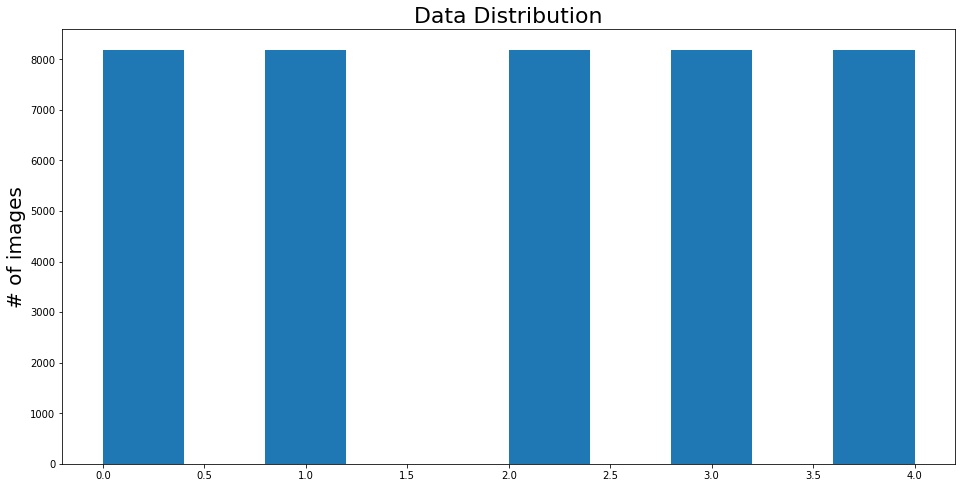

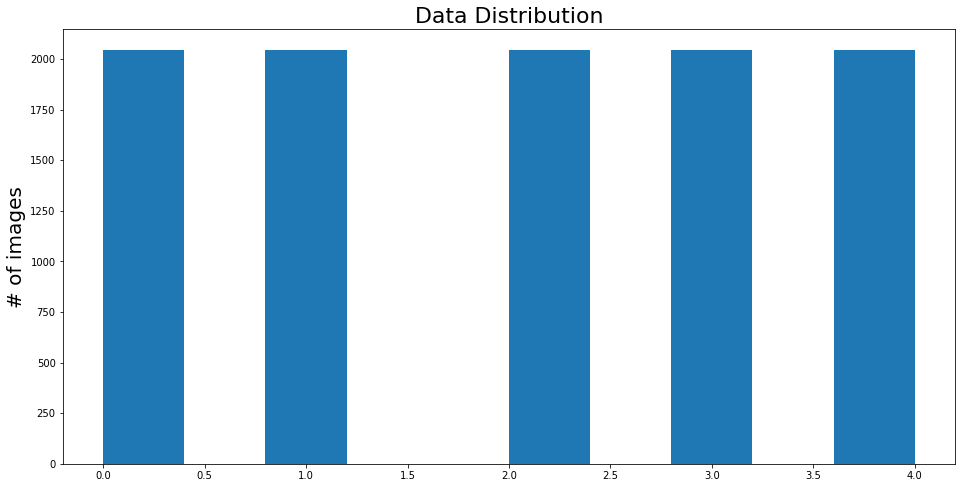

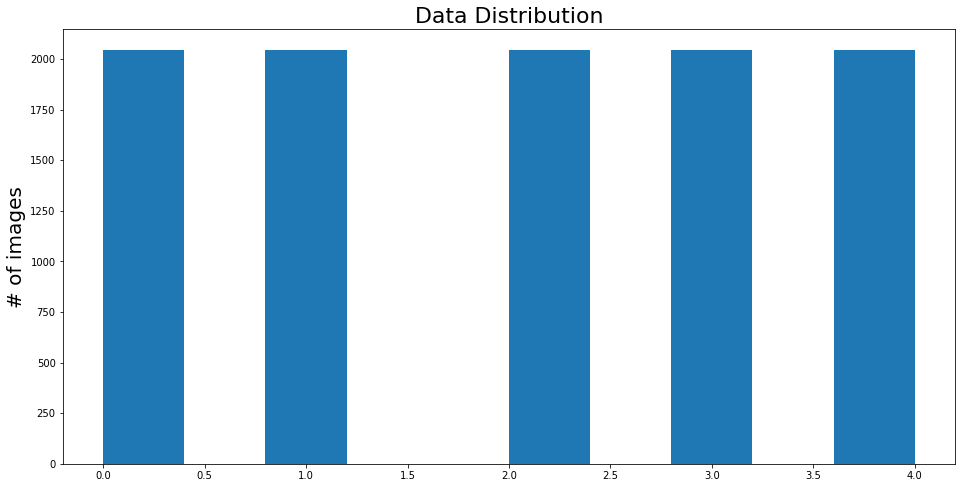

Epoch: 0 | Train Loss: 0.92356| Validation loss: 1.73737
Epoch: 1 | Train Loss: 0.49545| Validation loss: 1.69444
Saving model checkpoint
Epoch: 2 | Train Loss: 0.39104| Validation loss: 0.81329
Saving model checkpoint
Epoch: 3 | Train Loss: 0.34385| Validation loss: 1.06663
Epoch: 4 | Train Loss: 0.31229| Validation loss: 0.67906
Saving model checkpoint
Epoch: 5 | Train Loss: 0.29041| Validation loss: 2.63153
Epoch: 6 | Train Loss: 0.27693| Validation loss: 0.61097
Saving model checkpoint
Epoch: 7 | Train Loss: 0.26738| Validation loss: 1.93635
Epoch: 8 | Train Loss: 0.25686| Validation loss: 0.91340
Saving model checkpoint
Epoch: 9 | Train Loss: 0.24588| Validation loss: 0.70486
Saving model checkpoint
Epoch: 10 | Train Loss: 0.24366| Validation loss: 0.60173
Saving model checkpoint
Epoch: 11 | Train Loss: 0.23851| Validation loss: 0.59336
Saving model checkpoint
Epoch: 12 | Train Loss: 0.22932| Validation loss: 0.74986
Epoch: 13 | Train Loss: 0.22022| Validation loss: 0.62227
Saving

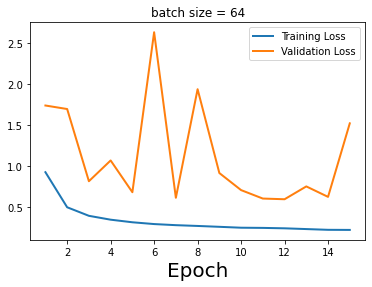

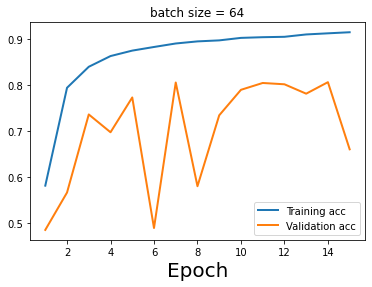

Accuracy for class: MHD_beta10 is 27.2 %
Accuracy for class: CR_Advect_beta10 is 70.2 %
Accuracy for class: CR_Diff_Fiducial_beta10 is 100.0 %
Accuracy for class: CR_Diff100_beta10 is 54.0 %
Accuracy for class: CR_withStreaming_beta10 is 81.7 %


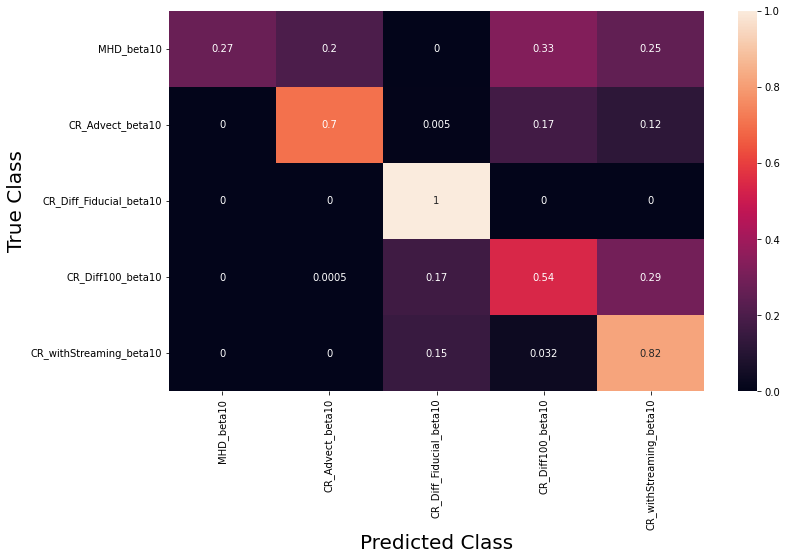

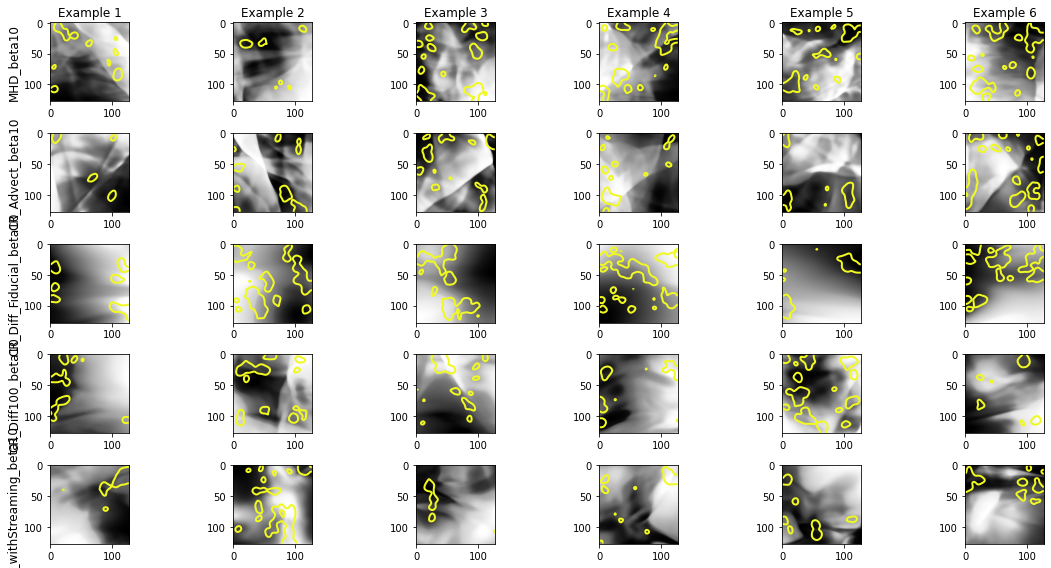

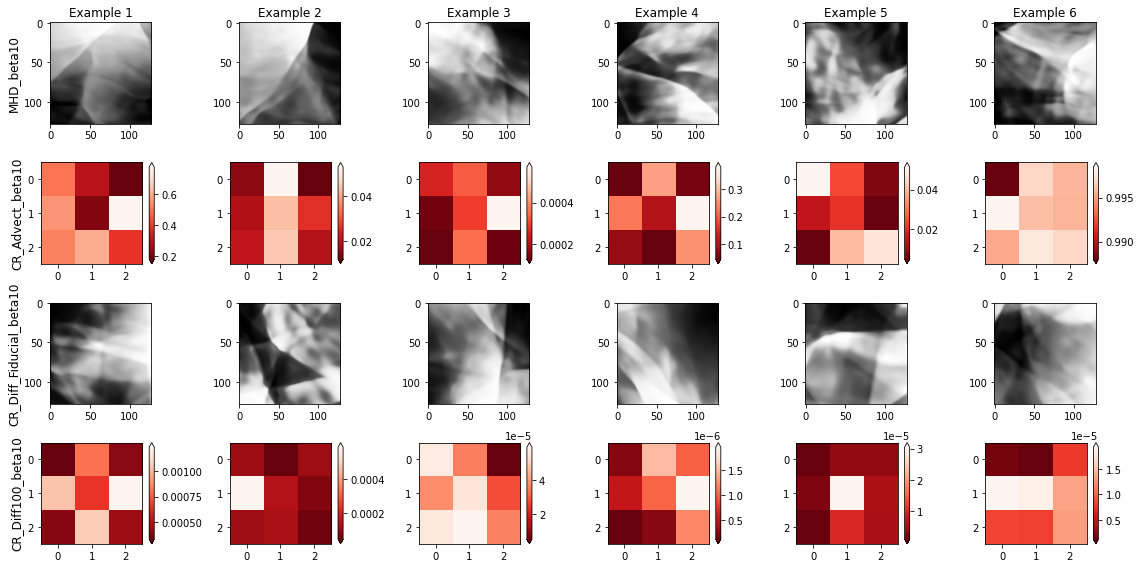

In [8]:
# Run a series of models to tune hyperparameters
torch.cuda.empty_cache()

# TODO: Log and store metrics and associated checkpoint files in folders
# TODO: Create a composite figure showing losses for different hyperparams

save_dir = 'runs/'
config.save_dir = save_dir
!mkdir 'runs'

p = 0.25 # dropout fraction

for batch_size in [64]:
  run_name = 'batch_size_'+str(batch_size)
  config.batch_size = batch_size
  config.run_name = run_name+'_pdrop_025'

  # change how many epochs it runs for?
  config.epochs = 15
  
  # load data (this needs to be done again when batch_size changes)
  train_dl, valid_dl, test_dl = load_data.preprocess(config)

  # create the model
  model, loss_fn, opt, tracker_train, tracker_val = create_model(config, p)

  # run new model
  run_output = fit(config, model.to(device), loss_fn, opt, train_dl, valid_dl,
                   tracker_train, tracker_val)
  
  model_trained, loss_arr_train, loss_arr_val = run_output


  total_train_metrics = tracker_train.compute_all()
  total_val_metrics = tracker_val.compute_all()

  # plot loss
  plot_losses(config, loss_arr_train, loss_arr_val)

  # plot other metrics in met_list
  met_list = ['acc']
  plot_other_metrics(config, total_train_metrics, total_val_metrics, met_list)

  model_trained.eval()
  # create confusion matrix 
  fig = interp.confusion(config, model_trained.cpu(), valid_dl)
  fig.show()
  fig.savefig(config.save_dir+config.run_name+'_confusion.png',dpi=600)

  # plot saliency maps
  fig = interp.plot_saliency(config, model_trained.cpu(), valid_dl, 
                             n_examples = 6, n_classes = 5, levels = [0.6])
  fig.show()
  fig.savefig(config.save_dir+config.run_name+'_saliency.png',dpi=600)

  # quick occlusion experiment
  fig = interp.plot_occlusion(config, model_trained.cpu(), valid_dl,
                              n_examples=6, n_classes=2, label=0, occ_size=32, 
                              occ_stride=32, occ_pixel=0.5)
  fig.show()
  fig.savefig(config.save_dir+config.run_name+'_occlusion.png',dpi=600)

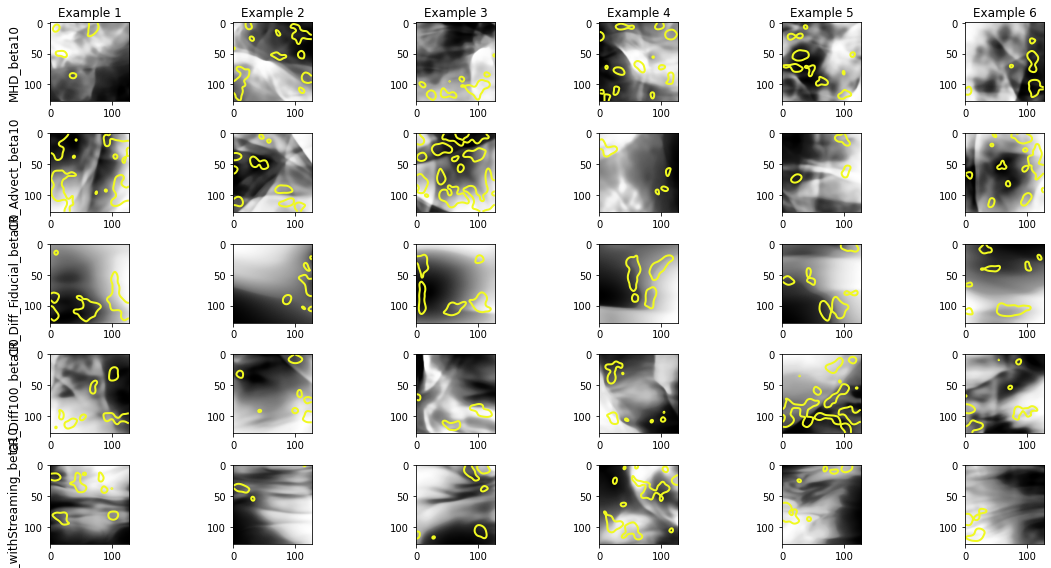

In [9]:
# plot saliency maps
fig = interp.plot_saliency(config, model_trained.cpu(), valid_dl, 
                             n_examples = 6, n_classes = 5, levels = [0.6])
fig.show()
fig.savefig(config.save_dir+config.run_name+'_saliency.png',dpi=600)

## Plot metrics

## Further analysis


In [10]:
# structure of the saved model

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.AdaptiveAvgPool2d(4), # works with any input size
    nn.Flatten(),
    nn.Linear(64*4*4,config.num_classes)
)
"""

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.AdaptiveAvgPool2d(4), # works with any input size
    nn.Flatten(),
    nn.Linear(32*4*4,config.num_classes)
)

"""
# path to checkpoint file
path_to_chk = 'runs/'

# load the saved model checkpoint
model.load_state_dict(torch.load(path_to_chk + config.run_name + '_checkpoint.pt',map_location=torch.device('cpu')))
model.eval()

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU()
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): SiLU()
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): SiLU()
  (11): Dropout(p=0.25, inplace=False)
  (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): SiLU()
  (15): Dropout(p=0.25, inplace=False)
  (16): AdaptiveAvgPool2d(output_size=4)
  (17): Flatten(start_dim=1, end_dim=-1)
  (18): Linear(in_features=1024, out_features=5, bias=Tr

Accuracy for class: MHD_beta10 is 92.3 %
Accuracy for class: CR_Diff_Fiducial_beta10 is 100.0 %


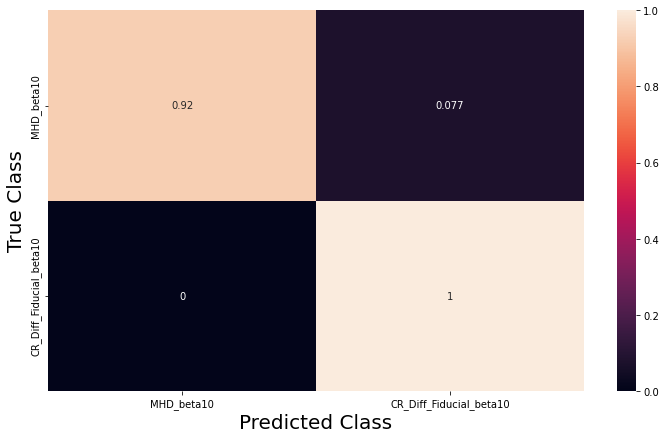

In [ ]:
# create confusion matrix 
fig = interp.confusion(config, model, valid_dl)
fig.show()
#fig.savefig('Confusion_Validation_KillPwr_twoClasses.png',dpi=600)

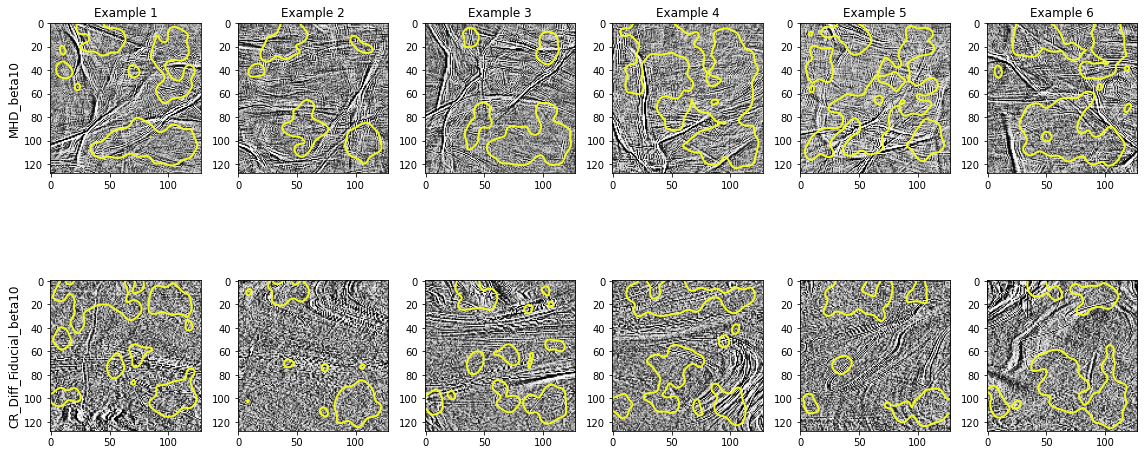

In [ ]:
# plot saliency maps
fig = interp.plot_saliency(config, model, valid_dl, n_examples = 6, n_classes = 2, levels = [0.6])
fig.show()
fig.savefig("Saliency_KillPwr_twoClasses.png",dpi=600)

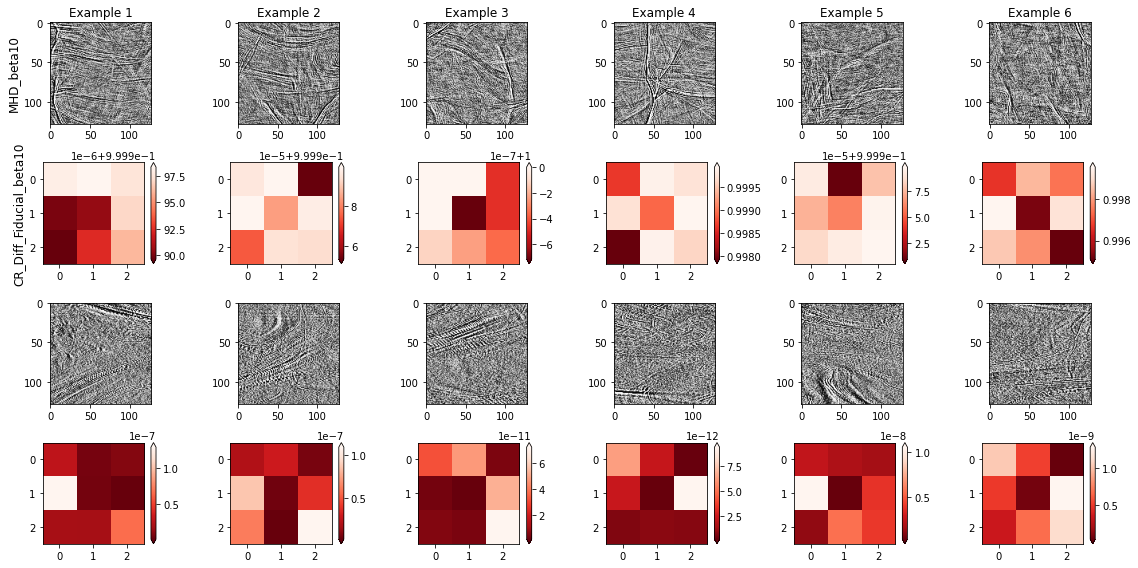

In [ ]:
# quick occlusion experiment
fig = interp.plot_occlusion(config, model, valid_dl, n_examples=6, n_classes=2,
                            label=0, occ_size=32, occ_stride=32, occ_pixel=0.5)
#fig.show()
fig.savefig('Occlusion_KillPwr_twoClasses.png',dpi=600)

## Further interpreting the network (Under construction)

In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=5220af80bcd5f87d96f5b81501cd44a03fe50afcffbc86d83911e532b07c381c
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [ ]:
# taken straight from this link for now: https://jacobgil.github.io/pytorch-gradcam-book/introduction.html

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2

#print(model.children)
#target
#target_layers = [model.children()[0]]
# how do you access layers from nn.Sequential??

target_layers = [model[-4]]

dataiter = iter(train_dl)
images, labels = next(dataiter)
img = images[0,:,:,:].numpy()
gray_img_float = np.float32(img) / 255

input_tensor = torch.from_numpy(gray_img_float).reshape(1,1,128,128)

# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers = target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

#targets = [ClassifierOutputTarget(1)]
targets = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
#grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(gray_img_float, grayscale_cam[0,:], use_rgb=True)

ValueError: ignored

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
# Create the metric target, often the confidence drop in a score of some category
metric_target = ClassifierOutputSoftmaxTarget(281)
scores, batch_visualizations = CamMultImageConfidenceChange()(input_tensor, 
  inverse_cams, targets, model, return_visualization=True)
visualization = deprocess_image(batch_visualizations[0, :])

# State of the art metric: Remove and Debias
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst
cam_metric = ROADMostRelevantFirst(percentile=75)
scores, perturbation_visualizations = cam_metric(input_tensor, 
  grayscale_cams, targets, model, return_visualization=True)

# You can also average accross different percentiles, and combine
# (LeastRelevantFirst - MostRelevantFirst) / 2
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage,
                                          ROADLeastRelevantFirstAverage,
                                          ROADCombined
cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams, targets, model)